# **Quantum Exact String Matching (ESM)**

In this tutorial, our focus lies on a Quantum Exact String Matching algorithm implementation. Its essence lies in identifying an occurrence of a specified pattern $x$, typically denoted by length $m$, within a text $y$ of length $n$ $\geq$ $m$, where both sequences are composed of characters taken from an alphabet $\Sigma$ of size $\sigma$. Our article presents an initial practical implementation of a quantum circuit tailored to address the exact string matching problem, particularly focusing on binary strings.

For instance, consider the pattern `101`. Within the text `11010100`, the pattern exhibits two occurrences.

A classical **naïve** approach exhibits a worst-case time complexity of $\mathcal{O}(mn)$, contrasting with the capability of quantum computation to achieve a $\tilde{O}(\sqrt{n})$ complexity using **Grover's search** - which searches a desired item within an unstructured dataset of size $n$, realizing a quadratic speed-up compared to classical methods.

This tutorial uses the **Qiskit** open-source toolkit developed by **IBM** and based on Python language. While current real-world hardware often struggles to produce valid results due to decoherence and quantum errors, particularly when dealing with lengthy texts, this study presents experimental results from a circuit simulation on classical hardware, validating the proposed implementation's efficacy.

In [ ]:
# Practical Implementation of a Quantum String Matching Algorithm
# S. Faro, F.P. Marino, and A. Scardace
# QUASAR 2024, ACM HPDC

%%capture
%pip install ibm-cloud-sdk-core==3.18.2
%pip install qiskit==0.45.1
%pip install qiskit-aer==0.13.1
%pip install pylatexenc==2.10

In [2]:
from numpy import log2, sqrt
from numpy import pi

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.gate import Gate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer
from qiskit import transpile

## Utility Functions

A first utility function is useful to execute a quantum circuit on the IBM simulator and retrieve the counts of measurement outcomes. It takes two parameters: the quantum circuit to be executed, and the number of repetitions of the circuit to run. After the circuit executions are completed, the function retrieves the result of the job and returns a dictionary containing the binary representation of measurement outcomes and their respective counts. Overall, this function helps us avoid duplication of code.

In [3]:
def run(circuit: QuantumCircuit, shots: int) -> dict:
    simulator = Aer.get_backend('aer_simulator')
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    return result.get_counts(compiled_circuit)

This function initializes a quantum register based on the given binary string, which represents its initial state. The function applies an $X$ gate to the $i$-th qubit of the quantum register if `bin_str[i] = 1`. Overall, this function enables the convenient initialization of a quantum register, allowing for the preparation of specific quantum states for further quantum computation.

In [4]:
def init_register(bin_str: str) -> QuantumCircuit:
    data_qr = QuantumRegister(len(bin_str), 'data')
    qc = QuantumCircuit(data_qr)

    for i, bit in enumerate(bin_str):
        if bit == '1':
            qc.x(data_qr[i])

    return qc

Let's try to build the circuit for a $4$-qubit register.

In [5]:
classical_value = '1001'
init_register(classical_value).draw(fold=255)

┌───┐
data_0: ┤ X ├
        └───┘
data_1: ─────
             
data_2: ─────
        ┌───┐
data_3: ┤ X ├
        └───┘

## The Parameterized Cyclic Rotation Operator

In this section, we present the implementation of the quantum cyclic rotation operator, as described by **Pavone** and **Viola**. The circuit will then be integrated by a parameter that will allow the amplitude of the rotation to be applied to the quantum register to be arbitrarily defined. Furthermore, the operator is implemented to provide rotations **towards the left**.

This function implements a procedure that, using a series of SWAP gates, cyclically shifts a quantum register of size $n$ by $s = 2^k$ positions to the left. The depth of the final quantum circuit does not exceed the value $\log(n)$. As a result of this rotation, the qubit at position $(i+s)\bmod{n}$ of the register is moved to position $i$, where $0\leq i < n$.

In [6]:
def rot(n: int, s: int) -> QuantumCircuit:
    y_qr = QuantumRegister(n, 'y')
    qc = QuantumCircuit(y_qr, name='ROT_' + str(s))

    for i in range(1, (int(log2(n)) - int(log2(s)) + 2)):
        for j in range(int(n / (s * (2**i)))):
            for q in range(j * s * (2**i), s * (j*2 ** i+1)):
                qc.swap(n - 1 - (q+s), n - 1 - (q+2 ** (i-1) * s + s))

    return qc

Let's try to build the circuit for an $8$-qubit register and apply a rotation of 2 positions.

In [7]:
num_qubits = 8
shift_value = 2
rot(num_qubits, shift_value).draw(fold=255)

y_0: ──────────X─────X─
               │     │ 
y_1: ───────X──┼──X──┼─
            │  │  │  │ 
y_2: ────X──┼──┼──┼──┼─
         │  │  │  │  │ 
y_3: ─X──┼──┼──┼──┼──┼─
      │  │  │  │  │  │ 
y_4: ─┼──X──┼──┼──┼──X─
      │     │  │  │    
y_5: ─X─────┼──┼──X────
            │  │       
y_6: ───────┼──X───────
            │          
y_7: ───────X──────────

Subsequently, it is necessary to create a function that allows to transform the rotation operator into a quantum gate. It enhances the versatility and modularity of quantum circuit design for the next quantum algorithm implementations.

In [8]:
def rot_gate(n: int, s: int) -> Gate:
    rot_circuit = rot(n, s)
    return rot_circuit.to_gate(label='ROT_' + str(s))

The following function creates a parameterized version of the rotation operator. This circuit involves the use of a register $|j\rangle$ of $log(n)$ qubits, where $n$ is the size of the quantum register $|y\rangle$ on which to apply the rotation. The register $|j\rangle$ will contain the binary representation of the amplitude $s$ of the rotation to be applied, with $0 \leq s < n$. For any given value of $i$ such that $0 \leq i < \log(n)$, the application of the rotation operator $ROT$_${2^i}$ to register $|y\rangle$ is controlled by the qubit $|j_i\rangle$.

In [9]:
def parameterized_rot(n: int) -> QuantumCircuit:
    j_qr = QuantumRegister(int(log2(n)), 'j')
    y_qr = QuantumRegister(n, 'y')
    qc = QuantumCircuit(j_qr, y_qr)

    for i in range(int(log2(n))):
        crot = rot_gate(n, 2**i).control(1)
        qc = qc.compose(crot, [j_qr[i]] + y_qr[:])

    return qc

Below, we show the quantum circuit that is generated by the parameterized rotation operator acting on an $8$-qubit register.

In [10]:
num_qubits = 8
parameterized_rot(num_qubits).draw(fold=255)

j_0: ────■─────────────────────────
         │                         
j_1: ────┼─────────■───────────────
         │         │               
j_2: ────┼─────────┼─────────■─────
     ┌───┴────┐┌───┴────┐┌───┴────┐
y_0: ┤0       ├┤0       ├┤0       ├
     │        ││        ││        │
y_1: ┤1       ├┤1       ├┤1       ├
     │        ││        ││        │
y_2: ┤2       ├┤2       ├┤2       ├
     │        ││        ││        │
y_3: ┤3       ├┤3       ├┤3       ├
     │  ROT_1 ││  ROT_2 ││  ROT_4 │
y_4: ┤4       ├┤4       ├┤4       ├
     │        ││        ││        │
y_5: ┤5       ├┤5       ├┤5       ├
     │        ││        ││        │
y_6: ┤6       ├┤6       ├┤6       ├
     │        ││        ││        │
y_7: ┤7       ├┤7       ├┤7       ├
     └────────┘└────────┘└────────┘

It is now possible to compile the circuit operating in superposition, obtaining the $8$ possible configurations of the $|j\rangle$ register. At the time of measurement, only one of them will be observed. However, running the circuit $100$ times, highlights how all possible configurations are present as a result, each with an equal probability of being observed.

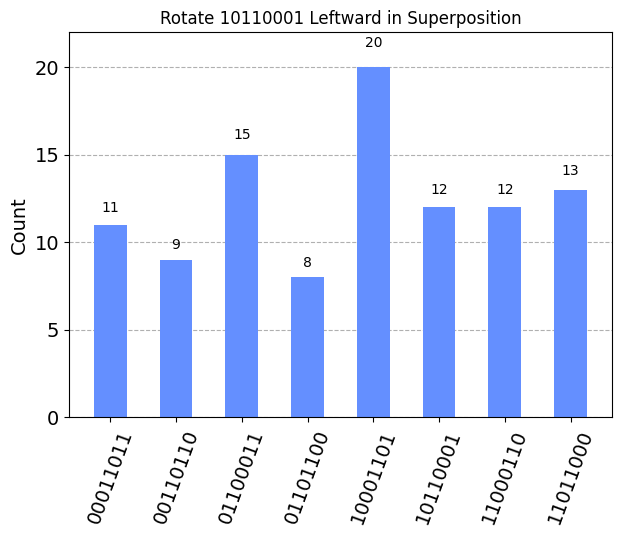

In [11]:
text = '10110001'
text_length = len(text)

shift_qr = QuantumRegister(int(log2(text_length)), 'shift')
text_qr = QuantumRegister(text_length, 'text')
output_cr = ClassicalRegister(text_length, 'output_classic')
circ = QuantumCircuit(shift_qr, text_qr, output_cr)

circ.h(shift_qr)
circ.append(init_register(text), text_qr[:])
circ.append(parameterized_rot(text_length), shift_qr[:] + text_qr[:])
circ.measure(text_qr, output_cr)

counts = run(circ, 100)
plot_histogram(counts, title='Rotate ' + text + ' Leftward in Superposition')

## The Match Operator

The Match operator allows comparison between two binary strings of equal length $m$. The comparison is performed to verify that the two strings are identical by altering the output qubit to $|1\rangle$ only if $x=y$. This comparison is carried out through $m$ CNOT gates running in parallel where $|x_i\rangle$ is used as control and $|y_i\rangle$ is used as the target. Subsequently, the qubits of the $|y\rangle$ register are negated. At this point, we will have $|y_i\rangle = |1\rangle$ if and only if $x_i=y_i$. Simply apply a multiple CNOT to verify that the register $|y\rangle$ is equal to $|1\rangle^m$. The circuit is completed by uncompute operations that restore the original values of $|x\rangle$ and $|y\rangle$.

In [12]:
def match(m: int) -> QuantumCircuit:
    x_qr = QuantumRegister(m, 'x')
    y_qr = QuantumRegister(m, 'y')
    out_qr = QuantumRegister(1, 'out')
    qc = QuantumCircuit(x_qr, y_qr, out_qr)

    for i in range(m):
        qc.cx(x_qr[i], y_qr[i])
        qc.x(y_qr[i])

    qc.mcx(y_qr[:], out_qr)

    for i in reversed(range(m)):
        qc.x(y_qr[i])
        qc.cx(x_qr[i], y_qr[i])

    return qc

Below, we show the circuit created by the Match operator if applied on strings of length $m=4$.

In [13]:
pattern_length = 4
match(pattern_length).draw(fold=255)

x_0: ──■─────────────────────────────────────────────────■──
       │                                                 │  
x_1: ──┼────■───────────────────────────────────────■────┼──
       │    │                                       │    │  
x_2: ──┼────┼────■─────────────────────────────■────┼────┼──
       │    │    │                             │    │    │  
x_3: ──┼────┼────┼────■───────────────────■────┼────┼────┼──
     ┌─┴─┐  │    │    │  ┌───┐     ┌───┐  │    │    │  ┌─┴─┐
y_0: ┤ X ├──┼────┼────┼──┤ X ├──■──┤ X ├──┼────┼────┼──┤ X ├
     └───┘┌─┴─┐  │    │  ├───┤  │  ├───┤  │    │  ┌─┴─┐└───┘
y_1: ─────┤ X ├──┼────┼──┤ X ├──■──┤ X ├──┼────┼──┤ X ├─────
          └───┘┌─┴─┐  │  ├───┤  │  ├───┤  │  ┌─┴─┐└───┘     
y_2: ──────────┤ X ├──┼──┤ X ├──■──┤ X ├──┼──┤ X ├──────────
               └───┘┌─┴─┐├───┤  │  ├───┤┌─┴─┐└───┘          
y_3: ───────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├───────────────
                    └───┘└───┘┌─┴─┐└───┘└───┘               
out: ─────────────────────────┤ X ├─────────────────────────
                              └───┘

In order to evaluate the functioning of the Match operator, we perform the comparison between a binary string $y = 1011$ and all the possible configurations of a $4$-bit binary string $x$ by applying the $H$ gate on each qubit of $|x\rangle$. The Match operator is then applied to the quantum registers $|x\rangle$ and $|y\rangle$ and you can easily see that just one solution has the last qubit equals to $|1\rangle$.

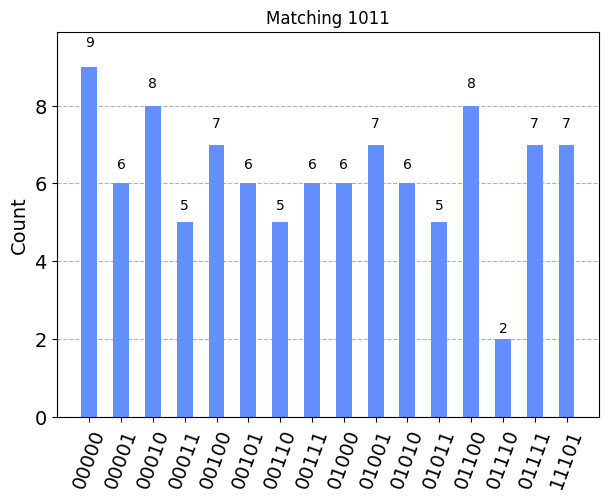

In [14]:
text = '1011'
text_length = len(text)

pattern_qr = QuantumRegister(text_length, 'pattern')
text_qr = QuantumRegister(text_length, 'text')
output_qr = QuantumRegister(1, 'output')
output_cr = ClassicalRegister(text_length + 1, 'output_classic')
circ = QuantumCircuit(pattern_qr, text_qr, output_qr, output_cr)

circ.h(pattern_qr)
circ.append(init_register(text), text_qr[:])
circ.append(match(text_length), pattern_qr[:] + text_qr[:] + output_qr[:])
circ.measure(pattern_qr, output_cr[:-1])
circ.measure(output_qr, output_cr[-1])

counts = run(circ, 100)
plot_histogram(counts, title='Matching ' + text)

Following that, it is necessary to create a function that allows to transform the exact match operator into a quantum gate. It takes one parameter: the length $m$ of the two strings we want to compare.

In [15]:
def match_gate(m: int) -> Gate:
    match_circuit = match(m)
    return match_circuit.to_gate(label='MATCH')

## The Exact String Matching Quantum Oracle

Through the use of the parameterized rotation operator and the match operator, it is now possible to implement an ESM operator to search for an exact occurrence of a pattern $x$ within a text $y$. It checks if a pattern is present as a prefix in a text, where the text $y$ is rotated by a certain shift value $j$ which can be in superposition, allowing for flexible alignment of the pattern within the text.

The shift value $s$ is encoded inside the quantum register $|j\rangle$. Two other quantum registers $|x\rangle$ and $|y\rangle$ are initialized to contain the two strings $x$ and $y$. Then, the text string is rotated $s$ positions to the left. This way, the string $y[s..s+m-1]$ will have been placed as a prefix in the quantum register $|y\rangle$. Using the MATCH operator, we compare the first $m$ qubits of $|x\rangle$ with the first $m$ qubits of $|y\rangle$ and the result of this comparison is recorded in $|out\rangle$. The circuit is completed by uncompute, which sets the values of the registers to their initial state.

In [16]:
def esm(m: int, n: int) -> QuantumCircuit:
    j_qr = QuantumRegister(int(log2(n)), 'j')
    x_qr = QuantumRegister(m, 'x')
    y_qr = QuantumRegister(n, 'y')
    out = QuantumRegister(1, 'out')

    qc = QuantumCircuit(
        j_qr,
        x_qr,
        y_qr,
        out
    )

    qc = qc.compose(parameterized_rot(n), j_qr[:] + y_qr[:])
    qc = qc.compose(match_gate(m), x_qr[:] + y_qr[:m] + out[:])
    qc = qc.compose(parameterized_rot(n).inverse(), j_qr[:] + y_qr[:])

    return qc

Below is the Boolean Oracle constructed for a pattern of length $m=2$ and a text of length $n=4$.

In [17]:
pattern_length = 2
text_length = 4
esm(pattern_length, text_length).draw(fold=255)

j_0: ────■────────────────────────────────────────────■──────
         │                                            │      
j_1: ────┼─────────■─────────────────────■────────────┼──────
         │         │     ┌────────┐      │            │      
x_0: ────┼─────────┼─────┤0       ├──────┼────────────┼──────
         │         │     │        │      │            │      
x_1: ────┼─────────┼─────┤1       ├──────┼────────────┼──────
     ┌───┴────┐┌───┴────┐│        │┌─────┴─────┐┌─────┴─────┐
y_0: ┤0       ├┤0       ├┤2       ├┤0          ├┤0          ├
     │        ││        ││        ││           ││           │
y_1: ┤1       ├┤1       ├┤3 MATCH ├┤1          ├┤1          ├
     │  ROT_1 ││  ROT_2 ││        ││  ROT_2_dg ││  ROT_1_dg │
y_2: ┤2       ├┤2       ├┤        ├┤2          ├┤2          ├
     │        ││        ││        ││           ││           │
y_3: ┤3       ├┤3       ├┤        ├┤3          ├┤3          ├
     └────────┘└────────┘│        │└───────────┘└───────────┘
out: ────────────────────┤4       ├──────────────────────────
                         └────────┘

 Next, it is necessary to create a function that allows to transform the ESM operator into a Quantum Boolean Oracle.

In [18]:
def esm_oracle(m: int, n: int):
    esm_circuit = esm(m, n)
    return esm_circuit.to_gate(label='ESMO')

## The Grover Search for a Fixed Number of Occurrences

The function below constructs a quantum gate representing the diffusion (reflection) operation which is used to amplify the amplitude of the desired solution state. The function takes one parameter: the number of qubits on which the diffusion operation is to be applied.

In [19]:
def diffuser(n: int) -> Gate:
    qc = QuantumCircuit(n)

    qc.h(range(n))
    qc.x(range(n))

    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)

    qc.x(range(n))
    qc.h(range(n))

    return qc.to_gate(label='DIFF')

The following function implements Grover's algorithm for solving a boolean function problem, where the objective is to search for a specific number of solutions satisfying a specified boolean function.<br/>
The function first calculates the number of iterations of Grover's algorithm required based on the number of solutions $t$ to search for and the length $n$ of $y$. It prepares the control qubits in superposition and applies the necessary quantum gates to initialize $|x\rangle$ and $|y\rangle$ with their respective values. It then iteratively applies the ESM oracle and the DIFFUSION gate. After that, the function **verifies** the solution found, by measuring the control qubits $|j\rangle$ and applying the ESM gate to check for an exact match.

In [20]:
def grover(esmo: Gate, t: int, x: str, y: str) -> QuantumCircuit:
    n = len(y)
    m = len(x)
    logn = int(log2(n))
    num_iterations = int(pi/4 * sqrt(n/t))

    j_qr = QuantumRegister(logn, 'j')
    x_qr = QuantumRegister(m, 'x')
    y_qr = QuantumRegister(n, 'y')
    out_qr = QuantumRegister(2, 'out')
    out_cr = ClassicalRegister(logn+1, 'c')
    qc = QuantumCircuit(j_qr, x_qr, y_qr, out_qr, out_cr)

    qc.h(j_qr)
    qc.x(out_qr[0])
    qc.h(out_qr[0])

    qc = qc.compose(init_register(x), x_qr[:])
    qc = qc.compose(init_register(y), y_qr[:])

    for _ in range(num_iterations):
        qc = qc.compose(esmo)
        qc = qc.compose(diffuser(logn))

    qc.measure(j_qr, out_cr[:-1])
    qc = qc.compose(esmo, j_qr[:] + x_qr[:] + y_qr[:] + [out_qr[1]])
    qc.measure(out_qr[1], out_cr[-1])

    return qc

Below, we show the quantum circuit that is generated by the GroverESM function.

In [21]:
x = '11'
y = '10101100'
esmo = esm_oracle(len(x), len(y))
grover(esmo, 1, x, y).draw(fold=255)

┌───┐     ┌────────┐┌───────┐┌────────┐┌───────┐┌─┐      ┌────────┐   
  j_0: ┤ H ├─────┤0       ├┤0      ├┤0       ├┤0      ├┤M├──────┤0       ├───
       ├───┤     │        ││       ││        ││       │└╥┘┌─┐   │        │   
  j_1: ┤ H ├─────┤1       ├┤1 DIFF ├┤1       ├┤1 DIFF ├─╫─┤M├───┤1       ├───
       ├───┤     │        ││       ││        ││       │ ║ └╥┘┌─┐│        │   
  j_2: ┤ H ├─────┤2       ├┤2      ├┤2       ├┤2      ├─╫──╫─┤M├┤2       ├───
       ├───┤     │        │└───────┘│        │└───────┘ ║  ║ └╥┘│        │   
  x_0: ┤ X ├─────┤3       ├─────────┤3       ├──────────╫──╫──╫─┤3       ├───
       ├───┤     │        │         │        │          ║  ║  ║ │        │   
  x_1: ┤ X ├─────┤4       ├─────────┤4       ├──────────╫──╫──╫─┤4       ├───
       ├───┤     │        │         │        │          ║  ║  ║ │        │   
  y_0: ┤ X ├─────┤5       ├─────────┤5       ├──────────╫──╫──╫─┤5       ├───
       └───┘     │        │         │        │          ║  ║  ║ │        │   
  y_1: ──────────┤6       ├─────────┤6       ├──────────╫──╫──╫─┤6       ├───
       ┌───┐     │   ESMO │         │   ESMO │          ║  ║  ║ │        │   
  y_2: ┤ X ├─────┤7       ├─────────┤7       ├──────────╫──╫──╫─┤7  ESMO ├───
       └───┘     │        │         │        │          ║  ║  ║ │        │   
  y_3: ──────────┤8       ├─────────┤8       ├──────────╫──╫──╫─┤8       ├───
       ┌───┐     │        │         │        │          ║  ║  ║ │        │   
  y_4: ┤ X ├─────┤9       ├─────────┤9       ├──────────╫──╫──╫─┤9       ├───
       ├───┤     │        │         │        │          ║  ║  ║ │        │   
  y_5: ┤ X ├─────┤10      ├─────────┤10      ├──────────╫──╫──╫─┤10      ├───
       └───┘     │        │         │        │          ║  ║  ║ │        │   
  y_6: ──────────┤11      ├─────────┤11      ├──────────╫──╫──╫─┤11      ├───
                 │        │         │        │          ║  ║  ║ │        │   
  y_7: ──────────┤12      ├─────────┤12      ├──────────╫──╫──╫─┤12      ├───
       ┌───┐┌───┐│        │         │        │          ║  ║  ║ │        │   
out_0: ┤ X ├┤ H ├┤13      ├─────────┤13      ├──────────╫──╫──╫─┤        ├───
       └───┘└───┘└────────┘         └────────┘          ║  ║  ║ │        │┌─┐
out_1: ─────────────────────────────────────────────────╫──╫──╫─┤13      ├┤M├
                                                        ║  ║  ║ └────────┘└╥┘
  c: 4/═════════════════════════════════════════════════╩══╩══╩════════════╩═
                                                        0  1  2            3

Here is what $3$ different executions of the generated quantum circuit show.

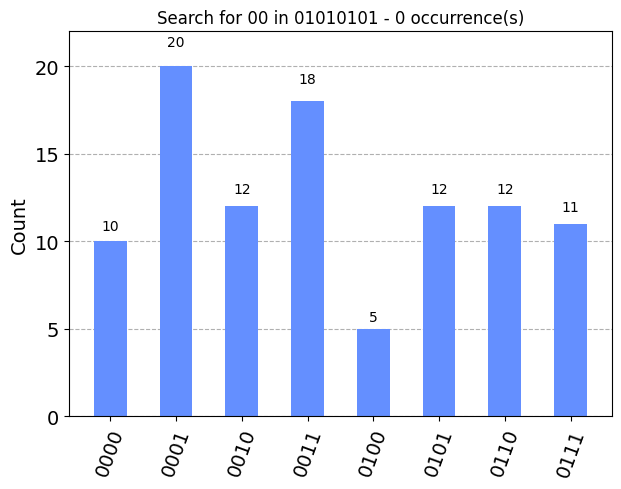

In [22]:
x = '00'
y = '01010101'
esmo = esm_oracle(len(x), len(y))
counts = run(grover(esmo, 1, x, y), 100)
plot_histogram(counts, title=f'Search for {x} in {y} - 0 occurrence(s)')

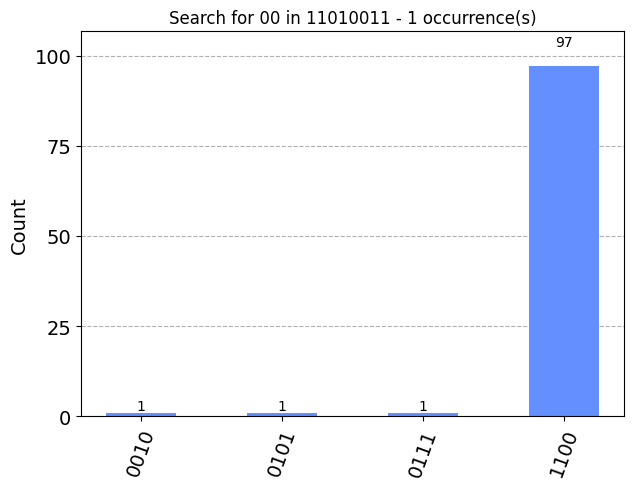

In [23]:
x = '00'
y = '11010011'
esmo = esm_oracle(len(x), len(y))
counts = run(grover(esmo, 1, x, y), 100)
plot_histogram(counts, title=f'Search for {x} in {y} - 1 occurrence(s)')

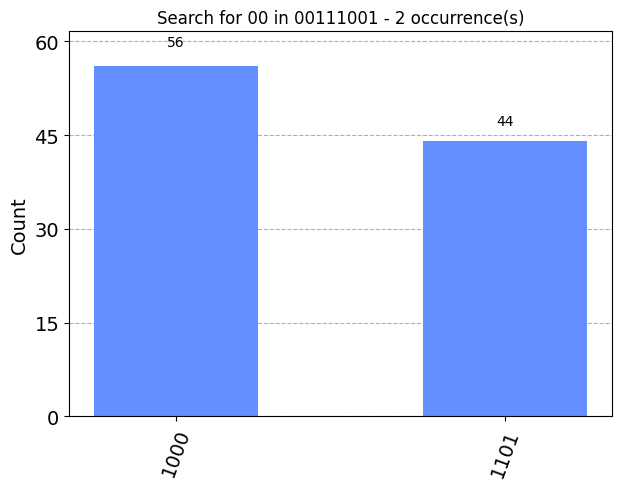

In [24]:
x = '00'
y = '00111001'
esmo = esm_oracle(len(x), len(y))
counts = run(grover(esmo, 2, x, y), 100)
plot_histogram(counts, title=f'Search for {x} in {y} - 2 occurrence(s)')

## Solving the General Case

In the general case, the value $t$ of occurrences is not known a priori and can only be obtained through a complex procedure based on the Quantum Phase Estimation. Since this algorithm works even if a correct $t^*$ estimate of $t$ is known, up to a small multiplicative error $1+\varepsilon$, several approximate counting solutions have also been proposed. An effective practical solution for this problem has been recently given by **Venkateswaran** and **O'Donnell**. It consists in adaptively estimating $t$ by trying all the possible values in the range $[1.1^i]$ for $1\leq i \leq \log_{1.1}(N/2)$, until a solution is found or, alternatively, responding negatively if no solutions are found. This approach requires a  total number of Grover iterations which is still $\tilde{O}(\sqrt{n})$.

In [25]:
def search(x: str, y: str) -> int:
    m = len(x)
    n = len(y)
    esmo = esm_oracle(m, n)

    for t in range(1, int(n/2) + 1):

        print('Trying with t =', t)
        results = run(grover(esmo, t, x, y), 1)
        results = list(results.keys())[0]
        outcome = int(results[0])
        position = int(results[1:], 2)

        if outcome: return position
        else: print('Pattern not found in position', position)

    return -1

<h2><b>Now come on, let's try it!</b></h2>
Just remember that:

- $x$ is the pattern of length $m$.
- $y$ is the text of length $n \geq m$.
- Both $x$ and $y$ must be binary strings.

In [ ]:
x = input('Enter the value of x: ')
y = input('Enter the value of y: ')

if len(x) > len(y):
    raise ValueError('The length of x must be shorter than the length of y.')

if not all(c in '01' for c in x):
    raise ValueError('The pattern must be a binary string.')

if not all(c in '01' for c in y):
    raise ValueError('The text must be a binary string.')

print('')
position = search(x, y)

if position >= 0: print('Pattern occurrence found in position', str(position))
else: print('Pattern occurrence not found.')

Enter the value of x: 00
Enter the value of y: 10100101

Trying with t = 1
Pattern occurrence found in position 3
